In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MaxAbsScaler
from sklearn.metrics import r2_score, mean_absolute_error

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

In [3]:
url_file = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat'
columns = ['frequency',
           'angle_of_attack', 
           'chord_length', 
           'free_stream_velocity',
           'suction_side_displacement_thickness',
           'scaled_sound_pressure_level']

features = ['frequency','angle_of_attack', 
            'chord_length', 
            'free_stream_velocity',
            'suction_side_displacement_thickness']

df = pd.read_csv(url_file, sep='\t', header=None, names=columns)

In [4]:
df.head()

,frequency,angle_of_attack,chord_length,free_stream_velocity,suction_side_displacement_thickness,scaled_sound_pressure_level
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [5]:
df.tail()

,frequency,angle_of_attack,chord_length,free_stream_velocity,suction_side_displacement_thickness,scaled_sound_pressure_level
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224
1502,6300,15.6,0.1016,39.6,0.052849,104.204


In [6]:
df.describe()

,frequency,angle_of_attack,chord_length,free_stream_velocity,suction_side_displacement_thickness,scaled_sound_pressure_level
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2886.380572,6.782302,0.136548,50.860745,0.011140,124.835943
std,3152.573137,5.918128,0.093541,15.572784,0.013150,6.898657
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.191000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.721000
75%,4000.000000,9.900000,0.228600,71.300000,0.015576,129.995500
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   frequency                            1503 non-null   int64  
 1   angle_of_attack                      1503 non-null   float64
 2   chord_length                         1503 non-null   float64
 3   free_stream_velocity                 1503 non-null   float64
 4   suction_side_displacement_thickness  1503 non-null   float64
 5   scaled_sound_pressure_level          1503 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.6 KB


In [8]:
def preprocess_input(df):
    
    train_data = df.copy()
    train_set = train_data.drop("scaled_sound_pressure_level", axis = 1)
    train_labels = train_data["scaled_sound_pressure_level"].copy()
    
    train_set = QuantileTransformer(random_state=0).fit_transform(train_set)
    train_set = MaxAbsScaler().fit_transform(train_set)
    train_set = StandardScaler().fit_transform(train_set)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(train_set, train_labels, test_size=0.2)
    
    return X_train, X_test, y_train, y_test

In [9]:
X_train, X_test, y_train, y_test = preprocess_input(df)

In [10]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1202, 5)
(301, 5)
(1202,)
(301,)


In [11]:
model = Sequential()

model.add(Input(X_train.shape[1],))

model.add(Dense(48, activation = 'relu'))

model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 48)                288       
                                                                 
 dense_1 (Dense)             (None, 1)                 49        
                                                                 
Total params: 337 (1.32 KB)
Trainable params: 337 (1.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
model.compile(loss = 'mean_squared_error', metrics = tf.keras.metrics.RootMeanSquaredError())

In [13]:
def get_shape(model):
    weights_layer = model.get_weights()
    shapes = []
    for weights in weights_layer:
        shapes.append(weights.shape)
    return shapes

In [14]:
def set_shape(weights,shapes):
    new_weights = []
    index=0
    for shape in shapes:
        if(len(shape)>1):
            n_nodes = np.prod(shape) + index
        else:
            n_nodes=shape[0]+index
        tmp = np.array(weights[index:n_nodes]).reshape(shape)
        new_weights.append(tmp)
        index=n_nodes
    return new_weights

In [15]:
shape = get_shape(model)
num_solutions = 20
dimensions = 337

In [16]:
def evaluate_nn(W):
    model.set_weights(set_shape(W,shape))
    score = model.evaluate(X_train, y_train, verbose = 0)
    return score[1]

In [17]:
from mealpy import GWO, FloatVar
lb = [-10 for i in range(dimensions)]
ub = [10 for i in range(dimensions)]

In [18]:
problem_dict = {
    "bounds": FloatVar(lb = lb, ub = ub, name="NeuralNetwork"),
    "minmax": "min",
    "obj_func": evaluate_nn
}

In [19]:
GWO_optimizer = GWO.OriginalGWO(epoch=1000, pop_size=15)

In [20]:
g_best = GWO_optimizer.solve(problem_dict)

2024/04/14 04:55:12 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: Solving single objective optimization problem.
2024/04/14 04:55:14 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 1, Current best: 126.9282455444336, Global best: 126.9282455444336, Runtime: 1.21517 seconds
2024/04/14 04:55:16 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 2, Current best: 126.9282455444336, Global best: 126.9282455444336, Runtime: 1.74453 seconds
2024/04/14 04:55:19 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 3, Current best: 126.9282455444336, Global best: 126.9282455444336, Runtime: 2.58172 seconds
2024/04/14 04:55:21 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 4, Current best: 108.82710266113281, Global best: 108.82710266113281, Runtime: 2.53127 seconds
2024/04/14 04:55:24 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 5, Current best: 96.86579132080078, Global best: 96.86579132080078, Runti

2024/04/14 04:56:51 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 46, Current best: 62.84446334838867, Global best: 62.84446334838867, Runtime: 2.60316 seconds
2024/04/14 04:56:54 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 47, Current best: 62.84446334838867, Global best: 62.84446334838867, Runtime: 2.50594 seconds
2024/04/14 04:56:57 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 48, Current best: 62.84446334838867, Global best: 62.84446334838867, Runtime: 2.63470 seconds
2024/04/14 04:56:59 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 49, Current best: 62.84446334838867, Global best: 62.84446334838867, Runtime: 2.34730 seconds
2024/04/14 04:57:01 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 50, Current best: 62.84446334838867, Global best: 62.84446334838867, Runtime: 2.12663 seconds
2024/04/14 04:57:02 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 51

2024/04/14 04:58:41 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 92, Current best: 54.2191276550293, Global best: 54.2191276550293, Runtime: 2.38341 seconds
2024/04/14 04:58:43 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 93, Current best: 54.2191276550293, Global best: 54.2191276550293, Runtime: 2.39356 seconds
2024/04/14 04:58:46 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 94, Current best: 54.2191276550293, Global best: 54.2191276550293, Runtime: 2.56947 seconds
2024/04/14 04:58:48 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 95, Current best: 54.2191276550293, Global best: 54.2191276550293, Runtime: 2.21630 seconds
2024/04/14 04:58:50 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 96, Current best: 54.2191276550293, Global best: 54.2191276550293, Runtime: 1.95207 seconds
2024/04/14 04:58:52 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 97, Current 

2024/04/14 05:00:26 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 138, Current best: 46.02005386352539, Global best: 46.02005386352539, Runtime: 2.06301 seconds
2024/04/14 05:00:28 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 139, Current best: 46.02005386352539, Global best: 46.02005386352539, Runtime: 2.13881 seconds
2024/04/14 05:00:30 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 140, Current best: 46.02005386352539, Global best: 46.02005386352539, Runtime: 1.85314 seconds
2024/04/14 05:00:32 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 141, Current best: 46.02005386352539, Global best: 46.02005386352539, Runtime: 2.06406 seconds
2024/04/14 05:00:35 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 142, Current best: 46.02005386352539, Global best: 46.02005386352539, Runtime: 3.04551 seconds
2024/04/14 05:00:38 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoc

2024/04/14 05:02:02 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 183, Current best: 34.01130676269531, Global best: 34.01130676269531, Runtime: 1.58736 seconds
2024/04/14 05:02:03 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 184, Current best: 34.01130676269531, Global best: 34.01130676269531, Runtime: 1.59364 seconds
2024/04/14 05:02:05 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 185, Current best: 34.01130676269531, Global best: 34.01130676269531, Runtime: 1.59154 seconds
2024/04/14 05:02:07 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 186, Current best: 34.01130676269531, Global best: 34.01130676269531, Runtime: 1.62294 seconds
2024/04/14 05:02:09 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 187, Current best: 34.01130676269531, Global best: 34.01130676269531, Runtime: 1.90400 seconds
2024/04/14 05:02:10 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoc

2024/04/14 05:03:19 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 228, Current best: 34.01130676269531, Global best: 34.01130676269531, Runtime: 1.63625 seconds
2024/04/14 05:03:21 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 229, Current best: 34.01130676269531, Global best: 34.01130676269531, Runtime: 1.76582 seconds
2024/04/14 05:03:23 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 230, Current best: 34.01130676269531, Global best: 34.01130676269531, Runtime: 1.95207 seconds
2024/04/14 05:03:24 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 231, Current best: 31.898475646972656, Global best: 31.898475646972656, Runtime: 1.72142 seconds
2024/04/14 05:03:26 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 232, Current best: 31.898475646972656, Global best: 31.898475646972656, Runtime: 1.61469 seconds
2024/04/14 05:03:28 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, 

2024/04/14 05:04:36 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 273, Current best: 28.034732818603516, Global best: 28.034732818603516, Runtime: 1.63966 seconds
2024/04/14 05:04:38 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 274, Current best: 28.034732818603516, Global best: 28.034732818603516, Runtime: 1.63127 seconds
2024/04/14 05:04:40 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 275, Current best: 28.034732818603516, Global best: 28.034732818603516, Runtime: 1.72057 seconds
2024/04/14 05:04:41 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 276, Current best: 28.034732818603516, Global best: 28.034732818603516, Runtime: 1.67489 seconds
2024/04/14 05:04:43 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 277, Current best: 28.034732818603516, Global best: 28.034732818603516, Runtime: 1.56904 seconds
2024/04/14 05:04:45 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Proble

2024/04/14 05:05:52 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 318, Current best: 19.73594856262207, Global best: 19.73594856262207, Runtime: 1.71007 seconds
2024/04/14 05:05:54 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 319, Current best: 19.73594856262207, Global best: 19.73594856262207, Runtime: 1.69870 seconds
2024/04/14 05:05:56 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 320, Current best: 19.73594856262207, Global best: 19.73594856262207, Runtime: 1.86819 seconds
2024/04/14 05:05:57 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 321, Current best: 19.73594856262207, Global best: 19.73594856262207, Runtime: 1.80186 seconds
2024/04/14 05:05:59 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 322, Current best: 19.73594856262207, Global best: 19.73594856262207, Runtime: 1.58845 seconds
2024/04/14 05:06:01 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoc

2024/04/14 05:07:38 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 363, Current best: 18.080400466918945, Global best: 18.080400466918945, Runtime: 2.78590 seconds
2024/04/14 05:07:40 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 364, Current best: 18.080400466918945, Global best: 18.080400466918945, Runtime: 2.82336 seconds
2024/04/14 05:07:43 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 365, Current best: 18.080400466918945, Global best: 18.080400466918945, Runtime: 2.74409 seconds
2024/04/14 05:07:46 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 366, Current best: 18.080400466918945, Global best: 18.080400466918945, Runtime: 2.74731 seconds
2024/04/14 05:07:48 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 367, Current best: 18.002294540405273, Global best: 18.002294540405273, Runtime: 2.42083 seconds
2024/04/14 05:07:51 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Proble

2024/04/14 05:09:04 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 408, Current best: 15.007576942443848, Global best: 15.007576942443848, Runtime: 1.64222 seconds
2024/04/14 05:09:06 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 409, Current best: 15.007576942443848, Global best: 15.007576942443848, Runtime: 1.51958 seconds
2024/04/14 05:09:08 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 410, Current best: 15.007576942443848, Global best: 15.007576942443848, Runtime: 1.69651 seconds
2024/04/14 05:09:09 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 411, Current best: 15.007576942443848, Global best: 15.007576942443848, Runtime: 1.64095 seconds
2024/04/14 05:09:11 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 412, Current best: 15.007576942443848, Global best: 15.007576942443848, Runtime: 1.68434 seconds
2024/04/14 05:09:13 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Proble

2024/04/14 05:11:04 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 453, Current best: 14.404349327087402, Global best: 14.404349327087402, Runtime: 2.51337 seconds
2024/04/14 05:11:06 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 454, Current best: 13.302617073059082, Global best: 13.302617073059082, Runtime: 2.64600 seconds
2024/04/14 05:11:09 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 455, Current best: 13.302617073059082, Global best: 13.302617073059082, Runtime: 2.75816 seconds
2024/04/14 05:11:12 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 456, Current best: 13.302617073059082, Global best: 13.302617073059082, Runtime: 2.73629 seconds
2024/04/14 05:11:15 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 457, Current best: 13.302617073059082, Global best: 13.302617073059082, Runtime: 2.73654 seconds
2024/04/14 05:11:17 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Proble

2024/04/14 05:13:01 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 498, Current best: 11.609681129455566, Global best: 11.609681129455566, Runtime: 2.55368 seconds
2024/04/14 05:13:04 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 499, Current best: 11.609681129455566, Global best: 11.609681129455566, Runtime: 3.00361 seconds
2024/04/14 05:13:06 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 500, Current best: 11.609681129455566, Global best: 11.609681129455566, Runtime: 2.81118 seconds
2024/04/14 05:13:09 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 501, Current best: 11.609681129455566, Global best: 11.609681129455566, Runtime: 2.73962 seconds
2024/04/14 05:13:12 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 502, Current best: 11.609681129455566, Global best: 11.609681129455566, Runtime: 2.62218 seconds
2024/04/14 05:13:14 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Proble

2024/04/14 05:14:44 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 543, Current best: 8.47186279296875, Global best: 8.47186279296875, Runtime: 1.73145 seconds
2024/04/14 05:14:46 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 544, Current best: 8.47186279296875, Global best: 8.47186279296875, Runtime: 1.96427 seconds
2024/04/14 05:14:47 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 545, Current best: 8.47186279296875, Global best: 8.47186279296875, Runtime: 1.86731 seconds
2024/04/14 05:14:49 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 546, Current best: 8.47186279296875, Global best: 8.47186279296875, Runtime: 1.64154 seconds
2024/04/14 05:14:51 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 547, Current best: 8.47186279296875, Global best: 8.47186279296875, Runtime: 1.88066 seconds
2024/04/14 05:14:53 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 548, Cu

2024/04/14 05:16:14 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 589, Current best: 8.47186279296875, Global best: 8.47186279296875, Runtime: 1.90226 seconds
2024/04/14 05:16:16 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 590, Current best: 8.47186279296875, Global best: 8.47186279296875, Runtime: 1.96577 seconds
2024/04/14 05:16:18 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 591, Current best: 8.47186279296875, Global best: 8.47186279296875, Runtime: 1.75647 seconds
2024/04/14 05:16:20 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 592, Current best: 8.47186279296875, Global best: 8.47186279296875, Runtime: 1.84595 seconds
2024/04/14 05:16:22 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 593, Current best: 8.47186279296875, Global best: 8.47186279296875, Runtime: 1.79359 seconds
2024/04/14 05:16:23 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 594, Cu

2024/04/14 05:17:39 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 634, Current best: 8.152891159057617, Global best: 8.152891159057617, Runtime: 1.67692 seconds
2024/04/14 05:17:40 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 635, Current best: 8.152891159057617, Global best: 8.152891159057617, Runtime: 1.78470 seconds
2024/04/14 05:17:42 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 636, Current best: 8.152891159057617, Global best: 8.152891159057617, Runtime: 1.63165 seconds
2024/04/14 05:17:44 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 637, Current best: 8.152891159057617, Global best: 8.152891159057617, Runtime: 1.55893 seconds
2024/04/14 05:17:45 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 638, Current best: 8.152891159057617, Global best: 8.152891159057617, Runtime: 1.69502 seconds
2024/04/14 05:17:47 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoc

2024/04/14 05:18:56 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 679, Current best: 7.22177267074585, Global best: 7.22177267074585, Runtime: 1.81008 seconds
2024/04/14 05:18:57 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 680, Current best: 7.22177267074585, Global best: 7.22177267074585, Runtime: 1.47902 seconds
2024/04/14 05:18:58 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 681, Current best: 7.22177267074585, Global best: 7.22177267074585, Runtime: 1.48563 seconds
2024/04/14 05:19:00 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 682, Current best: 7.22177267074585, Global best: 7.22177267074585, Runtime: 1.63662 seconds
2024/04/14 05:19:02 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 683, Current best: 7.22177267074585, Global best: 7.22177267074585, Runtime: 1.86728 seconds
2024/04/14 05:19:04 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 684, Cu

2024/04/14 05:20:14 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 725, Current best: 7.22177267074585, Global best: 7.22177267074585, Runtime: 1.56853 seconds
2024/04/14 05:20:15 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 726, Current best: 7.22177267074585, Global best: 7.22177267074585, Runtime: 1.81452 seconds
2024/04/14 05:20:17 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 727, Current best: 7.22177267074585, Global best: 7.22177267074585, Runtime: 1.88511 seconds
2024/04/14 05:20:19 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 728, Current best: 7.22177267074585, Global best: 7.22177267074585, Runtime: 1.70909 seconds
2024/04/14 05:20:21 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 729, Current best: 7.22177267074585, Global best: 7.22177267074585, Runtime: 1.50963 seconds
2024/04/14 05:20:22 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 730, Cu

2024/04/14 05:21:30 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 770, Current best: 6.783884048461914, Global best: 6.783884048461914, Runtime: 1.76705 seconds
2024/04/14 05:21:32 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 771, Current best: 6.783884048461914, Global best: 6.783884048461914, Runtime: 1.79556 seconds
2024/04/14 05:21:34 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 772, Current best: 6.783884048461914, Global best: 6.783884048461914, Runtime: 1.84429 seconds
2024/04/14 05:21:35 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 773, Current best: 6.783884048461914, Global best: 6.783884048461914, Runtime: 1.70065 seconds
2024/04/14 05:21:37 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 774, Current best: 6.783884048461914, Global best: 6.783884048461914, Runtime: 1.65959 seconds
2024/04/14 05:21:39 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoc

2024/04/14 05:22:46 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 815, Current best: 6.783884048461914, Global best: 6.783884048461914, Runtime: 1.72094 seconds
2024/04/14 05:22:48 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 816, Current best: 6.7600555419921875, Global best: 6.7600555419921875, Runtime: 1.70420 seconds
2024/04/14 05:22:49 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 817, Current best: 6.7600555419921875, Global best: 6.7600555419921875, Runtime: 1.65175 seconds
2024/04/14 05:22:51 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 818, Current best: 6.7600555419921875, Global best: 6.7600555419921875, Runtime: 1.76902 seconds
2024/04/14 05:22:53 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 819, Current best: 6.7600555419921875, Global best: 6.7600555419921875, Runtime: 1.72609 seconds
2024/04/14 05:22:55 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem:

2024/04/14 05:24:03 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 860, Current best: 6.277761936187744, Global best: 6.277761936187744, Runtime: 1.66025 seconds
2024/04/14 05:24:05 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 861, Current best: 6.277761936187744, Global best: 6.277761936187744, Runtime: 1.58854 seconds
2024/04/14 05:24:06 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 862, Current best: 6.277761936187744, Global best: 6.277761936187744, Runtime: 1.74209 seconds
2024/04/14 05:24:08 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 863, Current best: 6.277761936187744, Global best: 6.277761936187744, Runtime: 1.61168 seconds
2024/04/14 05:24:10 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 864, Current best: 6.277761936187744, Global best: 6.277761936187744, Runtime: 1.59848 seconds
2024/04/14 05:24:11 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoc

2024/04/14 05:25:21 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 906, Current best: 6.018109321594238, Global best: 6.018109321594238, Runtime: 1.91881 seconds
2024/04/14 05:25:23 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 907, Current best: 6.018109321594238, Global best: 6.018109321594238, Runtime: 1.78025 seconds
2024/04/14 05:25:25 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 908, Current best: 6.005679130554199, Global best: 6.005679130554199, Runtime: 1.65490 seconds
2024/04/14 05:25:26 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 909, Current best: 5.9445881843566895, Global best: 5.9445881843566895, Runtime: 1.72368 seconds
2024/04/14 05:25:28 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 910, Current best: 5.9445881843566895, Global best: 5.9445881843566895, Runtime: 1.92402 seconds
2024/04/14 05:25:30 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, 

2024/04/14 05:26:39 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 951, Current best: 5.504655361175537, Global best: 5.504655361175537, Runtime: 1.66816 seconds
2024/04/14 05:26:41 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 952, Current best: 5.504655361175537, Global best: 5.504655361175537, Runtime: 1.80438 seconds
2024/04/14 05:26:42 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 953, Current best: 5.504655361175537, Global best: 5.504655361175537, Runtime: 1.67061 seconds
2024/04/14 05:26:44 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 954, Current best: 5.504655361175537, Global best: 5.504655361175537, Runtime: 1.73810 seconds
2024/04/14 05:26:46 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 955, Current best: 5.482795238494873, Global best: 5.482795238494873, Runtime: 1.77490 seconds
2024/04/14 05:26:48 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoc

2024/04/14 05:27:55 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 996, Current best: 5.264688491821289, Global best: 5.264688491821289, Runtime: 1.72900 seconds
2024/04/14 05:27:57 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 997, Current best: 5.262923717498779, Global best: 5.262923717498779, Runtime: 1.90164 seconds
2024/04/14 05:27:59 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 998, Current best: 5.262416362762451, Global best: 5.262416362762451, Runtime: 1.75799 seconds
2024/04/14 05:28:01 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 999, Current best: 5.26175594329834, Global best: 5.26175594329834, Runtime: 1.69292 seconds
2024/04/14 05:28:02 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 1000, Current best: 5.26175594329834, Global best: 5.26175594329834, Runtime: 1.65322 seconds


In [21]:
solution = g_best.solution
model.set_weights(set_shape(solution, shape))

In [22]:
# RMSE
score = model.evaluate(X_train, y_train)
train_rmse, train_mse = score[1], score[0]

score = model.evaluate(X_test, y_test)
test_rmse, test_mse = score[1], score[0]

print("Train RMSE = ", train_rmse)
print("Test RMSE = ", test_rmse)
print("---------------------------")

#MSE
print("Train MSE = ", train_mse)
print("Test MSE = ", test_mse)
print("---------------------------")

#R2 Score
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
train_r2_score = r2_score(y_train, y_train_pred)
test_r2_score = r2_score(y_test, y_test_pred)

print("Train R2 = ", train_r2_score)
print("Test R2 = ", test_r2_score)
print("-----------------------------")

# MAE
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
print("Train MAE = ", train_mae)
print("Test MAE = ", test_mae)

10/10 [==============================] - 0s 2ms/step - loss: 30.6242 - root_mean_squared_error: 5.5339
Train RMSE =  5.26175594329834
Test RMSE =  5.533913612365723
---------------------------
Train MSE =  27.686077117919922
Test MSE =  30.62419891357422
---------------------------
10/10 [==============================] - 0s 2ms/step
Train R2 =  0.4252448483907759
Test R2 =  0.3206279126942646
-----------------------------
Train MAE =  4.21764848396187
Test MAE =  4.28014741997703


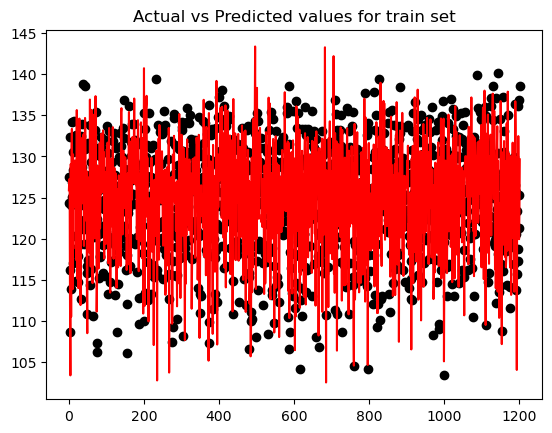

In [23]:
# scatter and line plot for train set

x_values = np.array([i for i in range(X_train.shape[0])])
plt.scatter(x_values, y_train, color = 'black', label = 'Actual values')
plt.plot(x_values, y_train_pred, color = 'red', label = 'Predicted values')
plt.title('Actual vs Predicted values for train set')
plt.show()

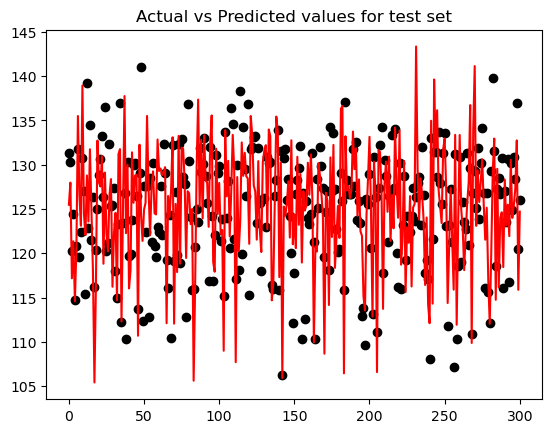

In [24]:
# scatter and line plot for test set

x_values = np.array([i for i in range(X_test.shape[0])])
plt.scatter(x_values, y_test, color = 'black', label = 'Actual values')
plt.plot(x_values, y_test_pred, color = 'red', label = 'Predicted values')
plt.title('Actual vs Predicted values for test set')
plt.show()